In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
from datetime import datetime
from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopandas.tools import overlay

sns.set(style="whitegrid")

In [2]:
requests_link = "./data/311_requests.csv"
requests_tmp = pd.read_csv(requests_link)

# almost 18,000 requests are being geocoded to the same place
tmp = requests_tmp.groupby('Latitude').count().sort_values(by='open_dt',ascending=False)

# pull out those requests and take it out for now
odd = requests_tmp.loc[requests_tmp.Latitude==42.3594, ['Longitude', 'Latitude']]
requests = requests_tmp.drop(odd.index)

In [3]:
requests.head(1)

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,NaN,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App


In [4]:
requests['closed_dt'].fillna("2017-04-30 00:00:00", inplace=True)
requests.head(1)

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App


In [5]:
requests['open_dt_date'] = pd.to_datetime(requests['open_dt'], format="%Y-%m-%d %H:%M:%S")
requests['closed_dt_date'] = pd.to_datetime(requests['closed_dt'], format="%Y-%m-%d %H:%M:%S")

In [6]:
requests.dtypes

CASE_ENQUIRY_ID             int64
open_dt                    object
target_dt                  object
closed_dt                  object
OnTime_Status              object
CASE_STATUS                object
CASE_TITLE                 object
SUBJECT                    object
REASON                     object
TYPE                       object
QUEUE                      object
Department                 object
Latitude                  float64
Longitude                 float64
Source                     object
open_dt_date       datetime64[ns]
closed_dt_date     datetime64[ns]
dtype: object

In [7]:
requests['open_len'] = requests['closed_dt_date'] - requests['open_dt_date']
requests['open_len_s'] = requests['open_len'].astype('timedelta64[s]')
print(requests.dtypes)

CASE_ENQUIRY_ID              int64
open_dt                     object
target_dt                   object
closed_dt                   object
OnTime_Status               object
CASE_STATUS                 object
CASE_TITLE                  object
SUBJECT                     object
REASON                      object
TYPE                        object
QUEUE                       object
Department                  object
Latitude                   float64
Longitude                  float64
Source                      object
open_dt_date        datetime64[ns]
closed_dt_date      datetime64[ns]
open_len           timedelta64[ns]
open_len_s                 float64
dtype: object


In [8]:
requests.head(1)

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source,open_dt_date,closed_dt_date,open_len,open_len_s
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App,2017-04-29 00:02:07,2017-04-30,23:57:53,86273.0


In [9]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(requests.Longitude, requests.Latitude)]
df = requests.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
r_geo = GeoDataFrame(df, crs=crs, geometry=geometry)

In [10]:
cb = gpd.read_file('./data/census2000blockgroups_poly/census2000blockgroups_poly.shp')
suffolk = cb.loc[cb['COUNTY'] == '025']
suffolk = suffolk.to_crs({'init': 'epsg:4326'})

In [11]:
suffolk.head()

,AREA,BG_ID,BLK_COUNT,BLOCKGROUP,COUNTY,CT_ID,DRY_ACRES,DRY_PCT,DRY_SQKM,DRY_SQMI,LOGRECNO,OBJECTID,PERIMETER,SAMP_POP,SHAPE_AREA,SHAPE_LEN,STATE,TOTAL_POP,TRACT,geometry
3801,136944.4990,250250001002,8,2,025,25025000100,33.84,1.0,0.14,0.053,0015169,3824,1532.9773,1004,136945.08470,1532.983397,25,982,000100,POLYGON ((-71.13089703892072 42.36069696794833...
3802,104342.6123,250250001003,11,3,025,25025000100,25.78,1.0,0.10,0.040,0015170,3825,1727.9928,734,104342.61115,1728.000682,25,796,000100,POLYGON ((-71.12965805378326 42.36064499970125...
3803,240201.0853,250250002011,15,1,025,25025000201,59.35,1.0,0.24,0.093,0015173,3827,2013.4407,937,240201.79040,2013.429038,25,905,000201,POLYGON ((-71.16243698749889 42.35631701466854...
3804,178741.8826,250250002013,6,3,025,25025000201,44.17,1.0,0.18,0.069,0015175,3829,2071.7515,1437,178743.19160,2071.748324,25,1406,000201,"POLYGON ((-71.1665479549896 42.35344602168698,..."
3805,80437.8849,250250002014,4,4,025,25025000201,19.88,1.0,0.08,0.031,0015176,3830,1152.7827,759,80435.59485,1152.776511,25,788,000201,POLYGON ((-71.16141198990212 42.34881704289953...


In [12]:
# spatial join requests to blocks
cb_r = gpd.sjoin(suffolk, r_geo, how="inner", op='intersects')
cb_r["count"] = 1

In [13]:
cb_r = cb_r[['BG_ID', 'Department', 'Source', 'open_len_s', 'count', 'geometry']]
cb_r.head()

,BG_ID,Department,Source,open_len_s,count,geometry
3801,250250001002,PWDx,Constituent Call,690024.0,1,POLYGON ((-71.13089703892072 42.36069696794833...
3801,250250001002,PWDx,Citizens Connect App,6369.0,1,POLYGON ((-71.13089703892072 42.36069696794833...
3801,250250001002,PWDx,Constituent Call,177223.0,1,POLYGON ((-71.13089703892072 42.36069696794833...
3801,250250001002,PWDx,Citizens Connect App,30760.0,1,POLYGON ((-71.13089703892072 42.36069696794833...
3801,250250001002,PWDx,Self Service,294125.0,1,POLYGON ((-71.13089703892072 42.36069696794833...


In [14]:
pd.set_option('display.max_columns', None)
cb_r_input = pd.get_dummies(cb_r, columns=['Source', 'Department'])
cb_r_input.head()

,BG_ID,open_len_s,count,geometry,Source_Citizens Connect App,Source_City Worker App,Source_Constituent Call,Source_Employee Generated,Source_Self Service,Source_Twitter,Department_ANML,Department_BHA_,Department_BPD_,Department_BPS_,Department_BTDT,Department_BWSC,Department_DISB,Department_DND_,Department_GEN_,Department_HS_D,Department_HS_O,Department_INFO,Department_ISD,Department_ONS_,Department_PARK,Department_PROP,Department_PWDx
3801,250250001002,690024.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,250250001002,6369.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,250250001002,177223.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,250250001002,30760.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,250250001002,294125.0,1,POLYGON ((-71.13089703892072 42.36069696794833...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
print(cb_r_input.columns)

Index(['BG_ID', 'open_len_s', 'count', 'geometry',
       'Source_Citizens Connect App', 'Source_City Worker App',
       'Source_Constituent Call', 'Source_Employee Generated',
       'Source_Self Service', 'Source_Twitter', 'Department_ANML',
       'Department_BHA_', 'Department_BPD_', 'Department_BPS_',
       'Department_BTDT', 'Department_BWSC', 'Department_DISB',
       'Department_DND_', 'Department_GEN_', 'Department_HS_D',
       'Department_HS_O', 'Department_INFO', 'Department_ISD',
       'Department_ONS_', 'Department_PARK', 'Department_PROP',
       'Department_PWDx'],
      dtype='object')


In [16]:
f = {'open_len_s': ['mean'], 
     'count': ['sum'], 
     'Source_Citizens Connect App': ['sum'], 
     'Source_City Worker App': ['sum'], 
     'Source_Constituent Call': ['sum'], 
     'Source_Employee Generated': ['sum'], 
     'Source_Self Service': ['sum'], 
     'Source_Twitter': ['sum'], 
     'Department_ANML': ['sum'], 
     'Department_BHA_': ['sum'], 
     'Department_BPS_': ['sum'], 
     'Department_BTDT': ['sum'], 
     'Department_BWSC': ['sum'], 
     'Department_DISB': ['sum'], 
     'Department_DND_': ['sum'], 
     'Department_GEN_': ['sum'], 
     'Department_HS_D': ['sum'], 
     'Department_HS_O': ['sum'], 
     'Department_INFO': ['sum'], 
     'Department_ISD': ['sum'], 
     'Department_ONS_': ['sum'], 
     'Department_PARK': ['sum'], 
     'Department_PROP': ['sum'], 
     'Department_PWDx': ['sum'], 
    }

In [17]:
cb_r_input_av = cb_r_input.groupby('BG_ID').agg(f)
cb_r_input_av.head()

,open_len_s,count,Source_Citizens Connect App,Source_City Worker App,Source_Constituent Call,Source_Employee Generated,Source_Self Service,Source_Twitter,Department_ANML,Department_BHA_,Department_BPS_,Department_BTDT,Department_BWSC,Department_DISB,Department_DND_,Department_GEN_,Department_HS_D,Department_HS_O,Department_INFO,Department_ISD,Department_ONS_,Department_PARK,Department_PROP,Department_PWDx
,mean,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
BG_ID,,,,,,,,,,,,,,,,,,,,,,,,
250250001001,533340.653226,124,42.0,23,44,8,7,0,0,0,0,13,0,0,0,1,0,0,11,4,0,1,4,90.0
250250001002,570769.771084,83,26.0,9,37,9,2,0,0,0,0,8,1,0,0,0,0,0,0,12,0,6,0,56.0
250250001003,525536.541667,72,46.0,6,13,3,4,0,0,0,0,26,0,0,0,0,0,0,1,4,0,0,4,37.0
250250001004,874883.819672,61,22.0,4,26,4,5,0,0,0,0,15,0,0,0,0,0,0,2,9,0,0,5,30.0
250250002011,321589.419355,93,31.0,10,41,5,6,0,0,0,0,13,0,0,0,0,0,0,3,1,0,1,0,75.0


In [18]:
# scale before clustering
cb_r_input_av_scale = pd.DataFrame(\
                 scale(cb_r_input_av), \
                 index=cb_r_input_av.index, \
                 columns=cb_r_input_av.columns)\
       .rename(lambda x: str(int(x)))
cb_r_input_av_scale.head()

,open_len_s,count,Source_Citizens Connect App,Source_City Worker App,Source_Constituent Call,Source_Employee Generated,Source_Self Service,Source_Twitter,Department_ANML,Department_BHA_,Department_BPS_,Department_BTDT,Department_BWSC,Department_DISB,Department_DND_,Department_GEN_,Department_HS_D,Department_HS_O,Department_INFO,Department_ISD,Department_ONS_,Department_PARK,Department_PROP,Department_PWDx
,mean,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
BG_ID,,,,,,,,,,,,,,,,,,,,,,,,
250250001001,-0.443940,0.643559,0.128798,1.908716,0.391482,1.210436,0.839132,-0.401082,-0.376693,-0.084504,-0.191273,-0.154830,-0.647954,-0.128928,-0.131938,0.052109,-0.042914,-0.060746,2.434923,-0.663475,-0.214834,-0.486509,0.352131,1.094467
250250001002,-0.333010,-0.088449,-0.306733,0.240315,0.034413,1.478545,-0.407421,-0.401082,-0.376693,-0.084504,-0.191273,-0.458026,0.197338,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.868314,0.386505,-0.214834,0.654270,-0.382516,0.081696
250250001003,-0.467069,-0.284841,0.237680,-0.117200,-1.189824,-0.130112,0.091200,-0.401082,-0.376693,-0.084504,-0.191273,0.633478,-0.647954,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.568020,-0.663475,-0.214834,-0.714665,0.352131,-0.484264
250250001004,0.568302,-0.481234,-0.415615,-0.355543,-0.526696,0.137998,0.340511,-0.401082,-0.376693,-0.084504,-0.191273,-0.033552,-0.647954,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.267726,-0.007238,-0.214834,-0.714665,0.535793,-0.692776
250250002011,-1.071513,0.090090,-0.170629,0.359486,0.238452,0.406107,0.589821,-0.401082,-0.376693,-0.084504,-0.191273,-0.154830,-0.647954,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,0.032569,-1.057218,-0.214834,-0.486509,-0.382516,0.647657


In [19]:
# cluster data
km = cluster.KMeans(n_clusters=5)

In [20]:
kmcls = km.fit(cb_r_input_av_scale.values)

In [21]:
kmcls.labels_

array([0, 0, 3, 3, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 0,
       3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 1, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 1,
       1, 0, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 3, 3, 1, 3, 3, 0, 3, 0, 1, 3, 1,
       1, 3, 3, 3, 0, 0, 3, 2, 1, 1, 0, 0, 0, 0, 3, 1, 3, 4, 0, 0, 1, 0, 1,
       1, 3, 1, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 3, 3,
       3, 0, 2, 3, 1, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 3,
       0, 0, 1, 0, 2, 0, 0, 3, 2, 0, 3, 3, 0, 0, 0, 0, 1, 3, 0, 0, 3, 0, 3,
       0, 1, 0, 0, 0, 1, 3, 3, 0, 0, 0, 1, 0, 3, 3, 3, 3, 1, 0, 0, 4, 0, 1,
       1, 3, 2, 0, 1, 1, 1, 1, 3, 1, 0, 0, 1, 3, 0, 1, 2, 0, 1, 0, 0, 1, 3,
       3, 1, 2, 2, 3, 3, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 0, 3, 3, 0, 3, 0, 3, 3, 3, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 0, 3, 2,
       0, 0, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 0, 2,
       0, 0,

In [22]:
clusters = cb_r_input_av_scale.assign(cl=kmcls.labels_)

In [23]:
# join back to spatial
geo = suffolk[['BG_ID', 'geometry']]
print(type(geo))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [24]:
clusters = clusters.reset_index(drop=False)
clusters.columns = clusters.columns.droplevel(-1)
clusters.head()

,BG_ID,open_len_s,count,Source_Citizens Connect App,Source_City Worker App,Source_Constituent Call,Source_Employee Generated,Source_Self Service,Source_Twitter,Department_ANML,Department_BHA_,Department_BPS_,Department_BTDT,Department_BWSC,Department_DISB,Department_DND_,Department_GEN_,Department_HS_D,Department_HS_O,Department_INFO,Department_ISD,Department_ONS_,Department_PARK,Department_PROP,Department_PWDx,cl
0,250250001001,-0.443940,0.643559,0.128798,1.908716,0.391482,1.210436,0.839132,-0.401082,-0.376693,-0.084504,-0.191273,-0.154830,-0.647954,-0.128928,-0.131938,0.052109,-0.042914,-0.060746,2.434923,-0.663475,-0.214834,-0.486509,0.352131,1.094467,0
1,250250001002,-0.333010,-0.088449,-0.306733,0.240315,0.034413,1.478545,-0.407421,-0.401082,-0.376693,-0.084504,-0.191273,-0.458026,0.197338,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.868314,0.386505,-0.214834,0.654270,-0.382516,0.081696,0
2,250250001003,-0.467069,-0.284841,0.237680,-0.117200,-1.189824,-0.130112,0.091200,-0.401082,-0.376693,-0.084504,-0.191273,0.633478,-0.647954,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.568020,-0.663475,-0.214834,-0.714665,0.352131,-0.484264,3
3,250250001004,0.568302,-0.481234,-0.415615,-0.355543,-0.526696,0.137998,0.340511,-0.401082,-0.376693,-0.084504,-0.191273,-0.033552,-0.647954,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,-0.267726,-0.007238,-0.214834,-0.714665,0.535793,-0.692776,3
4,250250002011,-1.071513,0.090090,-0.170629,0.359486,0.238452,0.406107,0.589821,-0.401082,-0.376693,-0.084504,-0.191273,-0.154830,-0.647954,-0.128928,-0.131938,-0.234229,-0.042914,-0.060746,0.032569,-1.057218,-0.214834,-0.486509,-0.382516,0.647657,0


In [25]:
cl_geo = geo.merge(clusters, on='BG_ID')
print(type(cl_geo))

<class 'geopandas.geodataframe.GeoDataFrame'>


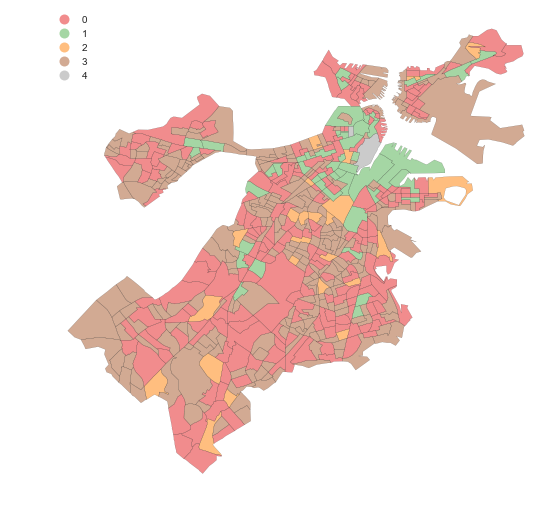

In [26]:
f, ax = plt.subplots(1, figsize=(9, 9))

cl_geo.plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, ax=ax, cmap='Set1')

ax.set_axis_off()

plt.show()

In [27]:
cols = list(cl_geo.ix[:,2:25].columns)
cols

['open_len_s',
 'count',
 'Source_Citizens Connect App',
 'Source_City Worker App',
 'Source_Constituent Call',
 'Source_Employee Generated',
 'Source_Self Service',
 'Source_Twitter',
 'Department_ANML',
 'Department_BHA_',
 'Department_BPS_',
 'Department_BTDT',
 'Department_BWSC',
 'Department_DISB',
 'Department_DND_',
 'Department_GEN_',
 'Department_HS_D',
 'Department_HS_O',
 'Department_INFO',
 'Department_ISD',
 'Department_ONS_',
 'Department_PARK',
 'Department_PROP']

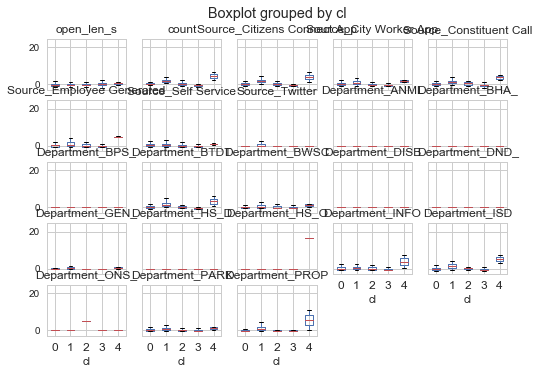

In [28]:
cl_geo.boxplot(cols, 'cl')
plt.show()

In [29]:
cols_subset = ["open_len_s", "count", "Source_Citizens Connect App", "Source_Constituent Call", "Source_Employee Generated",
             "Department_BWSC", "Department_BTDT", "Department_ISD", "Department_PROP", "Department_PARK"]

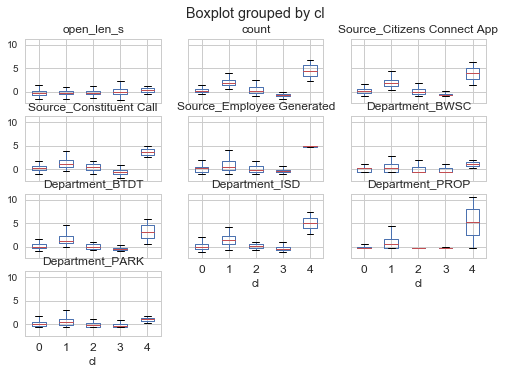

In [30]:
cl_geo.boxplot(cols_subset, 'cl')
plt.show()